# A `Sim`ple framework for `c`ontrastive `l`earning of visual `r`epresentation
<div style="text-align:center">
    <img src="https://1.bp.blogspot.com/--vH4PKpE9Yo/Xo4a2BYervI/AAAAAAAAFpM/vaFDwPXOyAokAC8Xh852DzOgEs22NhbXwCLcBGAsYHQ/s640/image4.gif" width="400" height="500">
</div>
<p style="text-align:center">Source: <a href="https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html">Google AI Blog</a></p>

In this kernel we will code a minimal implementation of [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/abs/2002.05709) by Chen et. al. With the analogy of the [Le Cake](https://youtu.be/7I0Qt7GALVk?t=2773) Yann LeCun quite warmly directs us into the realms of the unsupervised learning paradigm. The goal of unsupervised learning is to utilise the vast amount of unlabelled data to formalise a representation that helps in learning in general. SimCLR provides a great platform (and an easy one too) to help achieve a good representation out of unlabelled images. The itutions and conjectures provided by the paper comes quite naturally to one's mind. The ease of the concepts will be portrayed in the kernel along with some comments on the same.

SimCLR is based out of the following simplified modules:
- A stochastic data augmentation module.
- A neural network base encoder $f(.)$.
- A neural network projection head $g(.)$
- A contrastive loss function.


# Imports
The following imports will be used in the kernel.

In [7]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [8]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 2.2.2
DEVICE: cpu


# Stochastic Augmentation Module

In this section we will talk about the data pipeline. The authors suggest that a strong data augmentation is useful for unsupervised learning.
The following augmentation are suggested by the authors:
- Random Crop with Resize
- Random Horizontal Flip with 50% probability
- Random Color Distortion
    - Random Color Jitter with 80% probability
    - Random Color Drop with 20% probability
- Random Gaussian Blur with 50% probability

<div style="text-align:center">
    <img src="https://amitness.com/images/simclr-random-transformation-function.gif" width="400" height="500">
</div>
<p style="text-align:center">Source: <a href="https://amitness.com/2020/03/illustrated-simclr/">Amitness' take on SimCLR</a></p>

The data pipeline does not take an image and output a single augmented view, but on the contrary, outputs two randomly augmented views of the original image. The reason behind two distinct views will become simpler as we proceed to the next section.


In [9]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

## Prepare the Data
You can download Dataset from https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
In PyTorch we have two primitive classes to deal with data:
- torch.utils.data.DataSet
- torch.utils.data.DataLoader

The DataSet class helps in encapsulating the raw data. The DataLoader class helps in iterating over the DataSet that we make.


In [10]:

class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [11]:
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

image_dir = os.path.join(os.getcwd(), "input", "flowers-recognition", "*", "*.jpg")
image_paths = glob.glob(image_dir)

flowers_ds = CustomDataset(
    list_images=image_paths,
    transform=custom_transform
)


### Visualise the data pipeline

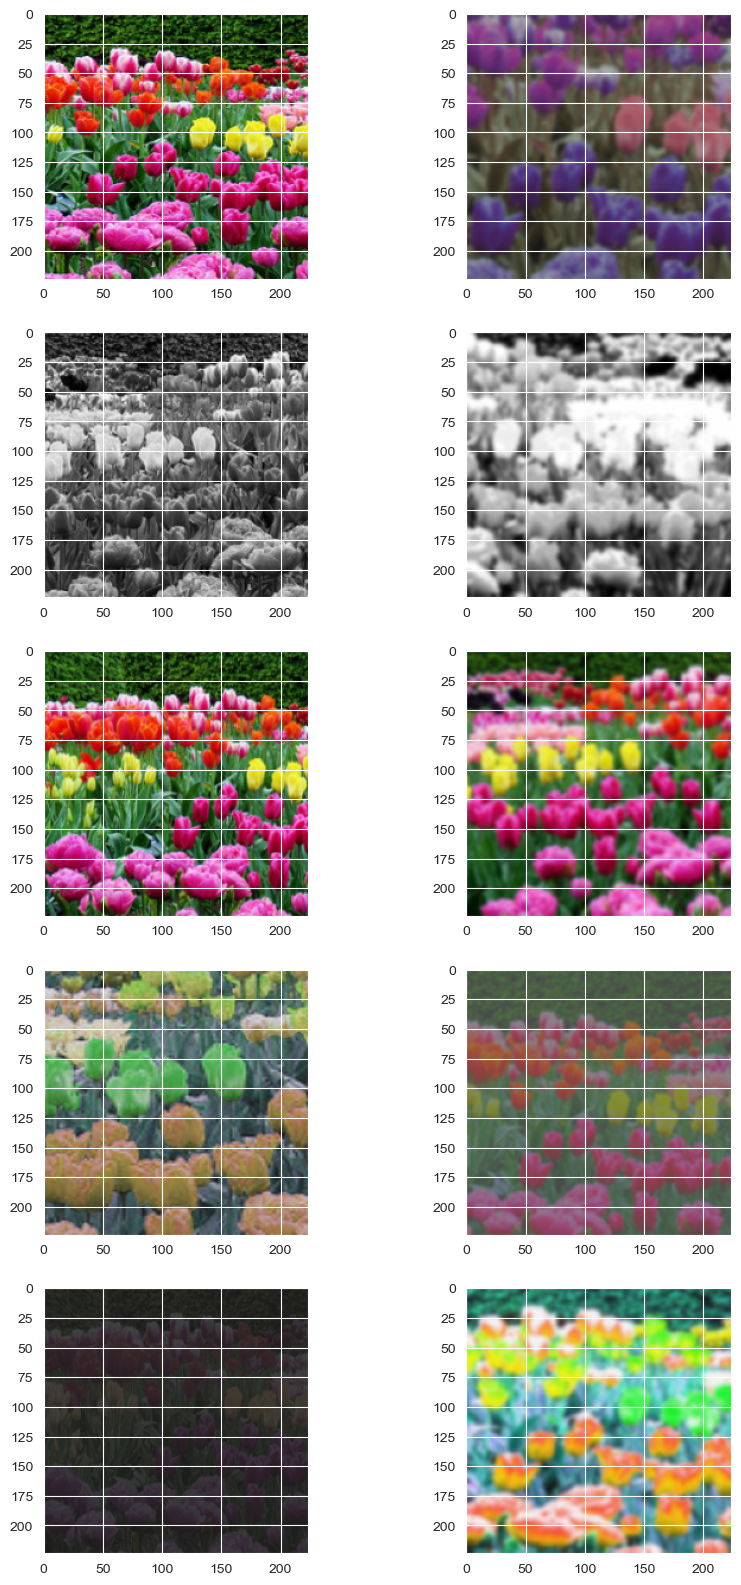

In [12]:
plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(flowers_ds,2000)

In [13]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

# SimCLR Model

As we remember the data pipeline gives us two augmented views of an image. The views go into a neural network encoder $f(.)$ that gives us the corresponding representation of the augmented views. Our objective is to maximise the similarity quotient of the two distinct learned representations. The idea here is to force the model to learn a general representation of an object from two distinct augmented views of it. The intuition is quite similar to viewing an object from different perspectives and gaining a better understanding.

The authors do not put constraint on the encoder model, here I have used ResNet18 as the data is quite small to use a bigger architecture. The similarity quotient comes from the representations learned by the encoder model. It was seen that projecting the encoded vector into a different latent space by an MLP helped in learning better (richer) representations. Here comes the projector $g(.)$ layer. The only objective of the projector is to project the encoder output to a richer latent space.

$$
h = f(x)\\
z = g(h)
$$

In [14]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

# Contrastive Loss

The loss function is basically built on top of two things:
- softmax
- cosine similarity

With the projected vectors we perform a cosine similarity function to check how similar they are. We perform the cosine similarity upon both the positive and negative pairs. After we have the similarity matrix we perform a softmax to have a probability distribution of the entire model. Our objective is to tune the knobs of the model so that this softmax distribution is peaked on the positive pair. The paper uses negative log of the softmax,  here we will approach a similar idea and use the cross entropy loss with the softmax similarity distribution. The authors have used the same approach in the [official code](https://github.com/google-research/simclr/blob/3ad6700c1b139ee18e43f73546b7263a710de699/objective.py#L82-L86) too.

In [15]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [16]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

/Users/qjming/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qjming/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/qjming/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/qjming/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'CustomDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

# Down Stream Task

After we have a trained SimCLR model we will discard the projection head and use the encoder only. We provide a `Centre Cropped` image to the encoder and get a learned representation of the images. This representation is then used in down stream tasks like classification.

Here we train the representations to predict the classification task provided with the flowers dataset.

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)

In [ ]:
resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])
image_dir=os.path.join(os.getcwd(), "input", "flowers-recognition")
# Get tuple (image,label)
flowers_ds = ImageFolder(
    root=image_dir,
    transform=custom_transform
)

nu_classes = len(flowers_ds.classes)

BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(512, nu_classes)
    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding) 
        return pred

In [ ]:
eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters())

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(train_dl):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = eval_model(image)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

# Visualize Distribution
The following t-SNE visualizations compare raw image data and features extracted by a SimCLR encoder. These plots demonstrate how contrastive learning encourages the model to structure the feature space more meaningfully, even without supervision.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np


raw_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# use ImageFolder to create dataset
flowers_ds = ImageFolder(
    root=image_dir,
    transform=raw_transform
)

# 显示类别映射（如：{'daisy': 0, 'rose': 1, ...}）
print("类别映射:", flowers_ds.class_to_idx)


# choose 30% of the dataset
total_len = len(flowers_ds)
subset_len = int(0.3 * total_len)

np.random.seed(42)
subset_indices = np.random.choice(total_len, subset_len, replace=False)

subset_ds = Subset(flowers_ds, subset_indices)
subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_with_labels(model, dataloader, device, title="Feature TSNE"):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = model(imgs)
            if isinstance(feats, tuple):  # 兼容 projection head
                feats = feats[0]
            features.append(feats.cpu())
            labels.append(lbls)

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_result = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="tab10", s=40)
    plt.title(title)
    plt.legend(loc="best", title="Class ID")
    plt.show()
    
def visualize_raw_pixels(dataloader, device, title="Raw Pixel TSNE"):
    features = []
    labels = []

    for imgs, lbls in dataloader:
        imgs = imgs.to(device)
        features.append(imgs.view(imgs.size(0), -1).cpu())
        labels.append(lbls)

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="tab10", s=40)
    plt.title(title)
    plt.legend(loc="best", title="Class ID")
    plt.show()


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


visualize_raw_pixels(subset_loader, DEVICE, title="Raw Image Distribution (30%)")


visualize_with_labels(simclr_model, subset_loader, DEVICE, title="After Contrastive Learning (30%)")


# Ending note
Thanks to Aritra Roy Gosthipaty for the original SimCLR implementation notebook that inspired this work.
https://www.kaggle.com/code/aritrag/simclr/notebook
